In [1]:
import os
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy
import matplotlib.pyplot as plt

In [2]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

h5_files = [os.path.join("../data/data_rand", f) for f in os.listdir('../data/data_rand') if f.endswith('.h5')]

df = analysis.load_outputs_to_dataframe(h5_files)
df = analysis.attach_hypotheses_fields(df, hypotheses)
print(len(df))

230


In [3]:
def filter_dataframe_by_range(df, field, lower_bound, upper_bound):
    """
    Filters the DataFrame to include only rows where the specified field's values
    are within the given range (exclusive).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        field (str): The column name to filter by.
        lower_bound (float): The lower bound of the range (exclusive).
        upper_bound (float): The upper bound of the range (exclusive).

    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    return df[(df[field] > lower_bound) & (df[field] < upper_bound)]

/tmp/ipykernel_215407/3014906693.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


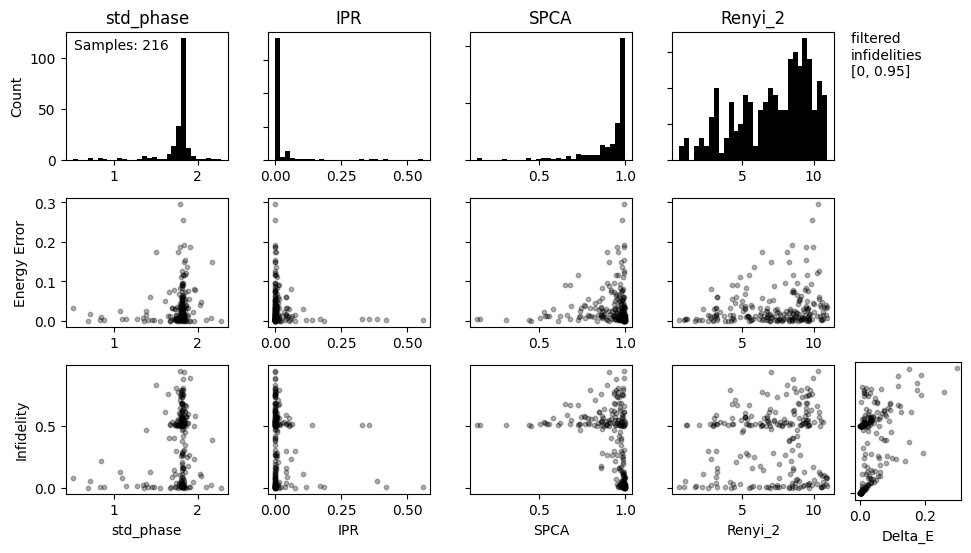

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

infidelityrange = (0, 0.95)
df_eval = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)
# df_eval = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)
# df_eval = filter_dataframe_by_range(df, 'Delta_E', *infidelityrange)

scatter_size = 10
N = len(hypotheses)
fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)

axes = np.empty((3, N), dtype=object)
for row in range(3):
    for col in range(N):
        axes[row, col] = fig.add_subplot(gs[row, col])

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram
    if name == "mean_phase":
        data = df_eval[name].abs()  # Use absolute value for mean_phase
        title = f"|{name}|"
    else:
        data = df_eval[name]
        title = name
    

    # axes[1, idx].set_yscale("log")
    # axes[2, idx].set_yscale("log")
    # axes[0, idx].set_xscale("log")
    # axes[1, idx].set_xscale("log")
    # axes[2, idx].set_xscale("log")
    # axes[0, idx].set_ylim(1e-3, 10)
    axes[0, idx].hist(data, bins=30, color="black")
    axes[0, idx].set_title(title)
    if idx == 0:
        axes[0, 0].set_ylabel("Count")
    else:
        axes[0, idx].tick_params(axis='y', labelleft=False)

    # Second row: Energy error vs hypothesis
    scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], alpha=0.3, s=scatter_size,color = "black")
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")
    else:
        axes[1, idx].tick_params(axis='y', labelleft=False)
    axes[2, idx].scatter(data, df_eval["infidelity"], alpha=0.3, s=scatter_size,color = "black")
    axes[2, idx].set_xlabel(title)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")
    else:
        axes[2, idx].tick_params(axis='y', labelleft=False)
# Colorbar in the rightmost column, spanning all rows
plt.tight_layout()
bottom_right_ax = fig.add_subplot(gs[-1, -1])
bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])  # Adjust position: [left, bottom, width, height]
bottom_right_ax.tick_params(axis='y', labelleft=False)
bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], alpha=0.3, s=scatter_size,color = "black")
bottom_right_ax.set_xlabel("Delta_E")
axes[0, 0].text(0.05, 0.95, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, 
                fontsize=10, color="black", ha="left", va="top")
lower_bound, upper_bound = infidelityrange
axes[-1, -1].text(1.1, 1, f"filtered \ninfidelities\n[{lower_bound}, {upper_bound}]", transform=axes[0, -1].transAxes, fontsize=10, color="black", ha="left", va="top")
plt.show()

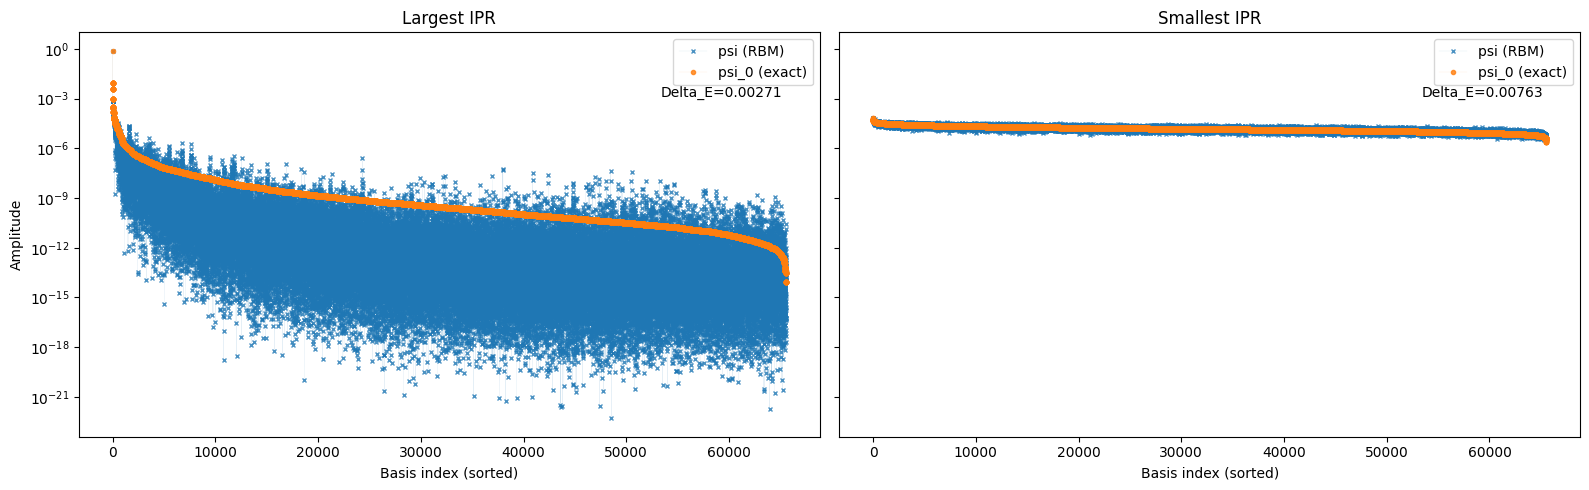

In [5]:
import numpy as np

# Find the index of the row with the largest IPR in df_eval
# Find indices of the row with largest and smallest IPR in df_eval
max_ipr_idx = df_eval["IPR"].idxmax()
min_ipr_idx = df_eval["IPR"].idxmin()

perm = np.argsort(df_eval["IPR"])
# max_ipr_idx = 45
# min_ipr_idx = 1

# Extract psi_0 and psi for those rows
psi_0_max_ipr = df_eval.loc[max_ipr_idx, "psi_0"]
psi_max_ipr = df_eval.loc[max_ipr_idx, "psi"]
psi_0_min_ipr = df_eval.loc[min_ipr_idx, "psi_0"]
psi_min_ipr = df_eval.loc[min_ipr_idx, "psi"]

perm_max_ipr = np.argsort(np.abs(psi_0_max_ipr))[::-1]
psi_0_max_ipr = psi_0_max_ipr[perm_max_ipr]
psi_max_ipr = psi_max_ipr[perm_max_ipr]

# For min IPR
perm_min_ipr = np.argsort(np.abs(psi_0_min_ipr))[::-1]
psi_0_min_ipr = psi_0_min_ipr[perm_min_ipr]
psi_min_ipr = psi_min_ipr[perm_min_ipr]

# Convert psi_0 and psi to numpy arrays for plotting
psi_0_max_ipr_arr = np.array(psi_0_max_ipr)
psi_max_ipr_arr = np.array(psi_max_ipr)
psi_0_min_ipr_arr = np.array(psi_0_min_ipr)
psi_min_ipr_arr = np.array(psi_min_ipr)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot wavefunctions with largest IPR
axs[0].plot(np.abs(psi_max_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[0].plot(np.abs(psi_0_max_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[0].set_xlabel('Basis index (sorted)')
axs[0].set_ylabel('Amplitude')
axs[0].set_yscale('log')
axs[0].set_title('Largest IPR')
axs[0].legend()

# Plot wavefunctions with IPR
axs[1].plot(np.abs(psi_min_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[1].plot(np.abs(psi_0_min_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[1].set_xlabel('Basis index (sorted)')
axs[1].set_yscale('log')
axs[1].set_title('Smallest IPR')
axs[1].legend()

axs[0].text(0.95, 0.85, f"Delta_E={df_eval.loc[max_ipr_idx, 'Delta_E']:.3g}", transform=axs[0].transAxes,
            fontsize=10, color="black", ha="right", va="center")
axs[1].text(0.95, 0.85, f"Delta_E={df_eval.loc[min_ipr_idx, 'Delta_E']:.3g}", transform=axs[1].transAxes,
            fontsize=10, color="black", ha="right", va="center")
plt.tight_layout()
plt.show()

Alternative: $$H = \sum_{<i,j>} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x + \epsilon H_\text{rand}$$

In [ ]:
h5_files = [os.path.join("data_rand_epsilon_TFI", f) for f in os.listdir('data_rand_epsilon_TFI') if f.endswith('.h5')]

df_eps = analysis.load_outputs_to_dataframe(h5_files)
df_eps = analysis.attach_hypotheses_fields(df_eps, hypotheses)
epsilons = [analysis.read_h5_attributes(f)["epsilon"] for f in h5_files]
df_eps["epsilon"] = epsilons
print(len(df_eps))

In [ ]:
from scipy.stats import pearsonr

def compute_pearson_correlation(series1, series2):
    correlation, p_value = pearsonr(series1, series2)
    return correlation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
infidelityrange = (0, 0.95)
df_eval = filter_dataframe_by_range(df_eps, 'infidelity', *infidelityrange)

scatter_size = 10
N = len(hypotheses)
fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)

axes = np.empty((3, N), dtype=object)
for row in range(3):
    for col in range(N):
        axes[row, col] = fig.add_subplot(gs[row, col])

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram
    if name == "mean_phase":
        data = df_eval[name].abs()  # Use absolute value for mean_phase
        title = f"|{name}|"
    else:
        data = df_eval[name]
        title = name
    

    # axes[1, idx].set_yscale("log")
    # axes[2, idx].set_yscale("log")

    axes[0, idx].hist(data, bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(title)
    if idx == 0:
        axes[0, 0].set_ylabel("Count")
    else:
        axes[0, idx].tick_params(axis='y', labelleft=False)

    # Second row: Energy error vs hypothesis
    scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], c=df_eval["epsilon"], cmap='viridis', alpha=0.8, s=scatter_size)
    correlation = compute_pearson_correlation(data, df_eval["Delta_E"])
    axes[1, idx].text(0.5, 0.9, f"r={correlation:.2f}", transform=axes[1, idx].transAxes, 
                      fontsize=10, color="black", ha="center", va="center")
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")
    else:
        axes[1, idx].tick_params(axis='y', labelleft=False)
    infid = df_eval["infidelity"]
    axes[2, idx].scatter(data, infid, c=df_eval["epsilon"], cmap='viridis', alpha=0.8, s=scatter_size)
    axes[2, idx].set_xlabel(title)
    correlation = compute_pearson_correlation(data, infid)
    axes[2, idx].text(0.5, 0.9, f"r={correlation:.2f}", transform=axes[2, idx].transAxes, 
                      fontsize=10, color="black", ha="center", va="center")
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")
    else:
        axes[2, idx].tick_params(axis='y', labelleft=False)
# Colorbar in the rightmost column, spanning all rows
plt.tight_layout()
cbar_ax = fig.add_subplot(gs[0:-1, -1])
bottom_right_ax = fig.add_subplot(gs[-1, -1])
bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])  # Adjust position: [left, bottom, width, height]
bottom_right_ax.tick_params(axis='y', labelleft=False)
bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], c=df_eval["epsilon"], cmap='viridis', alpha=0.8, s=scatter_size)
bottom_right_ax.set_xlabel("Delta_E")

correlation = compute_pearson_correlation(df_eval["Delta_E"], df_eval["infidelity"])
bottom_right_ax.text(0.5, 0.9, f"r={correlation:.2f}", transform=bottom_right_ax.transAxes, 
                      fontsize=10, color="black", ha="center", va="center")

axes[0, 0].text(0.5, 0.5, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, 
                fontsize=10, color="black", ha="center", va="center")

cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label("Epsilon")
lower_bound, upper_bound = infidelityrange
axes[-1, -1].text(1.1, 1.3, f"filtered infidelities\n[{lower_bound}, {upper_bound}]", transform=axes[0, -1].transAxes, fontsize=10, color="black", ha="left", va="top")
plt.show()

In [ ]:
df_eval["IPR"].idxmax()
perm.keys()

In [ ]:
df_eval.head()